## **Exact Diagonalization (ED) of the Transverse-Field Ising model in 1D:**

Here, we attempt to calculate the ground state and the ground state energy of the 1D Transverse-field Ising Model with periodic boundary conditions using Exact Diagonalization (ED).

The Hamiltonian is given as follows:

$$\hat{H}_{\text{TFIM}} = - \sum_{i = 1}^{N} \hat{\sigma}^{z}_i \hat{\sigma}^{z}_{i+1} - B_x \sum_{i=1}^{N} \hat{\sigma}^{x}_i $$

where ${\bf \hat{\sigma}}_i$ are pauli matrices and periodic boundary conditions are assumed.

### **1 - Calculating the ground state energy of 1DTFIM using Exact Diagonalization (ED) with a full representation**

It may take some time to do exact diagonalization. You can try up to $N=12$ spins otherwise you have to wait for a very long time.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['axes.labelsize']  = 20
rcParams['font.serif']      = ['Computer Modern']
rcParams['font.size']       = 10
rcParams['legend.fontsize'] = 20
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20

In [ ]:
def IsingMatrixElements(Bx,sigmap):
    """
    computes the matrix element of the Ising Hamiltonian for a given state sigmap
    -----------------------------------------------------------------------------------
    Parameters:
    sigmap:     np.ndarrray of dtype=int and shape (N)
                spin-state, integer encoded (using 0 for down spin and 1 for up spin)
                A sample of spins can be fed here.
    Bx: Transvers magnetic field
    -----------------------------------------------------------------------------------
    Returns: 2-tuple of type (np.ndarray,np.ndarray)
             sigmas:         np.ndarray of dtype=int and shape (?,N)
                             the states for which there exist non-zero matrix elements for given sigmap
             matrixelements: np.ndarray of dtype=float and shape (?)
                             the non-zero matrix elements
    """
    #the diagonal part is simply the sum of all Sz-Sz interactions
    diag=0

    sigmas=[]
    matrix_elements=[]
    N = sigmap.shape[0]


    ######## Answer to Q2
    for site in range(N):
        if sigmap[site]==sigmap[(site+1)%N]: #if the two neighouring spins are the same (We use Periodic Boundary Conditions)
            diag-=1 #add a negative energy contribution (We use ferromagnetic couplings)
        else:
            diag+=1 #add a positive energy contribution (when spins are opposite)

    matrix_elements.append(diag)
    sigmas.append(sigmap)

    #off-diagonal part (For the transverse Ising Model)
    if Bx != 0:
      for site in range(N):
              sig = np.copy(sigmap)
              sig[site] = np.abs(1-sig[site])
              matrix_elements.append(-Bx)
              sigmas.append(sig)

    return np.array(sigmas),np.array(matrix_elements)
'''
# Test:
N =4
sigmap =   np.random.choice([-1, 1], size=N) # np.array([0, 1, 0])  # random spin-state
Bx = 1.0  # Transverse magnetic field

sigmas, matrix_elements = IsingMatrixElements(Bx, sigmap)
for sigma, matrix_element in zip(sigmas, matrix_elements):
    print("State:", sigma, "Matrix Element:", matrix_element)
'''

'\n# Test:\nN =4\nsigmap =   np.random.choice([-1, 1], size=N) # np.array([0, 1, 0])  # random spin-state\nBx = 1.0  # Transverse magnetic field\n\nsigmas, matrix_elements = IsingMatrixElements(Bx, sigmap)\nfor sigma, matrix_element in zip(sigmas, matrix_elements):\n    print("State:", sigma, "Matrix Element:", matrix_element)\n'

In [ ]:
def ED_1DTFIM(N=10, Bx = 1):
  """
  Returns a tuple (eta,U)
    eta = a list of energy eigenvalues.
    U = a list of energy eigenvectors
  """

  basis = []
  #Generate a z-basis (all 2^N possibilities)
  for i in range(2**N):
      basis_temp = np.zeros((N))
      a = np.array([int(d) for d in bin(i)[2:]])
      l = len(a)
      basis_temp[N-l:] = a
      basis.append(basis_temp)
  basis = np.array(basis)

  H=np.zeros((basis.shape[0],basis.shape[0])) #prepare the hamiltonian
  for n in range(basis.shape[0]):
      ######## Answer to Q3
      sigmas,elements=IsingMatrixElements(Bx,basis[n])
      for m in range(sigmas.shape[0]):
          for b in range(basis.shape[0]):
              if np.all(basis[b,:]==sigmas[m,:]):
                  H[n,b]=elements[m]
                  break
  eta,U = np.linalg.eigh(H) #diagonalize
  return eta,U
# Test:
eta, U = ED_1DTFIM(N=10, Bx=1.0)
print("Eigenvalues:", eta)
print('E', np.min(eta))

Eigenvalues: [-12.78490644 -12.62750303 -11.53343072 ...  11.53343072  12.62750303
  12.78490644]
E -12.78490644299932


In [ ]:
eta, U = ED_1DTFIM(N=10, Bx = 1, J=1.0)  #"eta" corresponds to an array of eigenvalues and "U" corresponds to an array of eigenvectors
#-------------------------------------------- Complete Q4--------------------------------------------
E0 = np.min(eta)
print('E0: ', E0)


E0:  -100.0


### **2 - Calculating the ground state energy of 1DTFIM using Exact Diagonalization (ED) with a sparse representation**


Comments using the power method (Lanczos) and the sparce representation of the Hamiltonian.

Comment on the scipy.sparse package.

In [ ]:
import math
from functools import reduce
import scipy.linalg as sla
import scipy.sparse as sp
from scipy.optimize import curve_fit

In [ ]:
#
#	**********  BASIC MATRIX DEFINITIONS  **********
#

Sz = sp.dia_matrix([[1.0,0.0],[0.0,-1.0]])
Sx = sp.csc_matrix([[0.0,1.0],[1.0,0.0]])
Sy = sp.csc_matrix([[0.0,-1j],[1j,0.0]])

def Id(n): #defining the identity matrix
	return sp.eye(2**n)

def Szi(i,n): #defining the Sz operator at site i given n spins
	A = Id(i)
	B = Id(n-i-1)
	D = reduce(sp.kron, [A,Sz,B])
	return D

def Sxi(i,n): #defining the Sx operator at site i given n spins
	A = Id(i)
	B = Id(n-i-1)
	D = reduce(sp.kron, [A,Sx,B])
	return D

def interaction(c,i,j,n): #defining the SzSz operator at sites i, j given n spins
	if (i == j):
		print("i and j must be distinct!")
	elif (j<i):
		return interaction(c,j,i,n)
	else:
		A = Id(i)
		B = Id(j-i-1)
		C = Id(n-j-1)
		D = reduce(sp.kron, [A,Sz,B,Sz,C])
	return c*D


def NNterm(n): #defining the sum of SzSz terms
  #print 'Using Periodic BC'
  for i in range(n):
    if(i == 0):
      H = interaction(1,i,i+1,n)
    else:
      H = H + interaction(1,i,(i+1)%n,n)
  return H

def TrField(n): #defining the transverse magnetic field term
	for i in range(n):
		if (i == 0):
			F = Sxi(i,n)
		else:
			F = F + Sxi(i,n)
	return F

In [ ]:
def sparse_diag(N,Bx):
	"""
	a function that provides the spare diagonalization of the 1D TFIM model given a system size N and the transverse field Bx
	returns: (ground state energy, first excited energy, gap)
	"""

	trfield = TrField(N)
	interterm = NNterm(N)

	H = -sp.csc_matrix(interterm + Bx*trfield) #sparce representation of the Hamiltonian

	val = sp.linalg.eigsh(H,k=3,which='SA')[0]
	return val[0],val[2],val[2]-val[0]
	#	Note: val[1] corresponds to the first excited state energy numerically. However you will observe that val[1] will be equal to val[0] at Bx = 0 which is a consequence of the Z2 summetry of the 1D TFIM.

In [ ]:
#--------------------------- Complete Q6 ------------------------------------------
#sparse matrices


### Question 7 - check the scaling of the gap wih the system size on h = 0.5, 1.0, 2.0 up to N = 18. What do you observe?

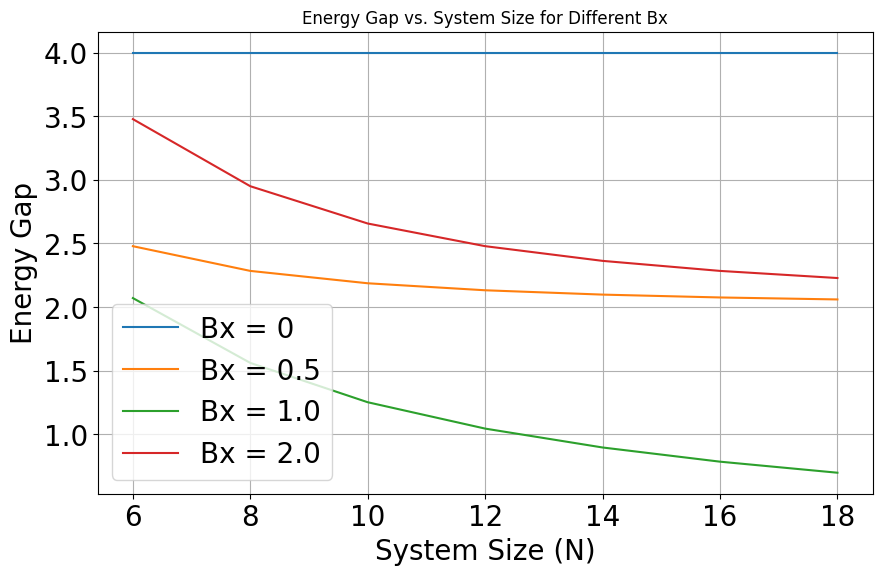

In [ ]:
#-------------------- Complete Q7------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def energy_gap(N, Bx):

    # Call the function to exactly diagonalize the Hamiltonian
    #eta, _ = ED_1DTFIM(N=N, Bx=Bx)
    eta= sparse_diag(N,Bx)

    # Extract the ground state energy and the energy of the first excited state
    ground_energy = eta[0]
    first_excited_energy = eta[1]

    # Compute the energy gap
    gap = first_excited_energy - ground_energy
    return gap

# Values of Bx to consider
Bx_values = [0, 0.5, 1.0, 2.0]

# Range of system sizes N
N_values = range(6, 19, 2)

# Compute energy gaps for each combination of N and Bx
energy_gaps = np.zeros((len(Bx_values), len(N_values)))
for i, Bx in enumerate(Bx_values):
    for j, N in enumerate(N_values):
        energy_gaps[i, j] = energy_gap(N, Bx)

# Plot the energy gaps as a function of system size N for each Bx
plt.figure(figsize=(10, 6))
for i, Bx in enumerate(Bx_values):
    plt.plot(N_values, energy_gaps[i], label=f'Bx = {Bx}')
plt.xlabel('System Size (N)')
plt.ylabel('Energy Gap')
plt.title('Energy Gap vs. System Size for Different Bx')
plt.legend()
plt.grid(True)
plt.show()



### Question 8: gap decay at Bx = 1

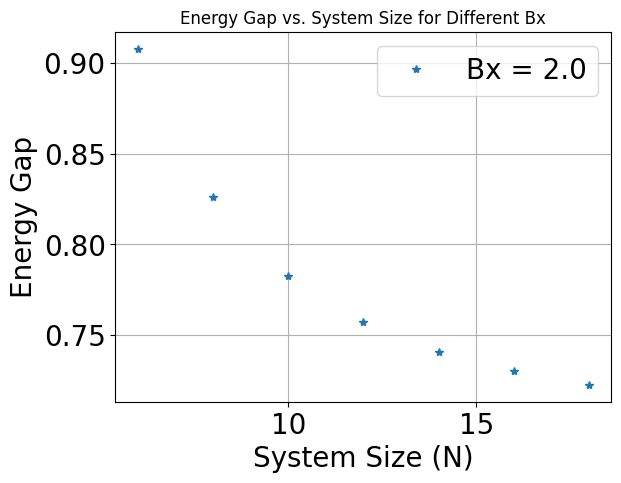

In [ ]:
#---------------------------------------Complete Q8----------------------------------------
plt.plot(N_values, np.log(energy_gaps[1]), '*', label=f'Bx = {Bx}')
plt.xlabel('System Size (N)')
plt.ylabel('Energy Gap')
plt.title('Energy Gap vs. System Size for Different Bx')
plt.legend()
plt.grid(True)
plt.show()